In [1]:
import torch
import torchvision
import torch.nn.functional as F

from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np

In [2]:
EPOCH = 15
BATCH_SIZE = 128
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Training Device: ", DEVICE)

Training Device:  cuda


In [3]:
trainset = datasets.FashionMNIST(root = "./.data/", train = True, download = True, transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

0it [00:00, ?it/s]

26427392it [00:08, 3254064.76it/s]                                                                                     


Extracting ./.data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./.data/FashionMNIST\raw


0it [00:00, ?it/s]

32768it [00:00, 37924.57it/s]                                                                                          
0it [00:00, ?it/s]

Extracting ./.data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./.data/FashionMNIST\raw


4423680it [00:04, 1012820.16it/s]                                                                                      
0it [00:00, ?it/s]

Extracting ./.data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST\raw


8192it [00:00, 12794.90it/s]                                                                                           

Extracting ./.data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST\raw
Processing...
Done!


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
            nn.Sigmoid(),)
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),)
        
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [5]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.00005)
criterion = nn.MSELoss()

In [6]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.1
    noisy_img = img + noise
    return noisy_img

In [7]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        x = add_noise(x)
        x = x.view(-1, 28 * 28).to(DEVICE)
        y = x.view(-1, 28 * 28).to(DEVICE)
        
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    return avg_loss / len(train_loader)

In [8]:
for epoch in range(1, EPOCH + 1):
    loss = train(autoencoder, train_loader)
    print("[EPOCH {}] loss: {}".format(epoch, loss))

[EPOCH 1] loss: 0.1520541895236542
[EPOCH 2] loss: 0.10226322461102309
[EPOCH 3] loss: 0.09774008433002906
[EPOCH 4] loss: 0.09726701811877395
[EPOCH 5] loss: 0.09713288557046512
[EPOCH 6] loss: 0.09709655630118302
[EPOCH 7] loss: 0.09705243574213117
[EPOCH 8] loss: 0.09703470861860938
[EPOCH 9] loss: 0.09705375017387781
[EPOCH 10] loss: 0.0970324417993204
[EPOCH 11] loss: 0.09702742584287993
[EPOCH 12] loss: 0.09703119258001161
[EPOCH 13] loss: 0.09702161114925006
[EPOCH 14] loss: 0.09702499893936775
[EPOCH 15] loss: 0.09703583082855383


In [9]:
testset = datasets.FashionMNIST(root = "./.data", train = False, download = True, transform = transforms.ToTensor())

In [10]:
sample_data = testset.data[0].view(-1, 28 * 28)
sample_data = sample_data.type(torch.FloatTensor) / 255.

In [11]:
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

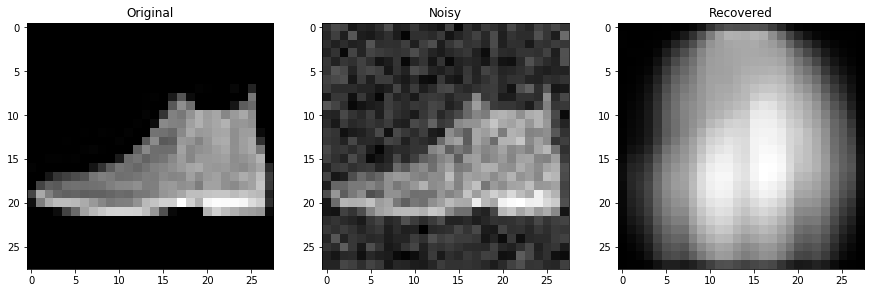

In [12]:
f, a = plt.subplots(1, 3, figsize = (15, 15))

original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

a[0].set_title("Original")
a[0].imshow(original_img, cmap = 'gray')

a[1].set_title("Noisy")
a[1].imshow(noisy_img, cmap = 'gray')

a[2].set_title("Recovered")
a[2].imshow(recovered_img, cmap = 'gray')
plt.show()